# Sesgos Semánticos: Embeddings vs Léxico

**Notebook:** Comparación de sesgos basados en embeddings  
**Versión:** 1.0  
**Fecha:** Diciembre 2025

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nicolakorff/tfm-endocrine-llm/blob/main/examples/03_demo_semantic.ipynb)

---

Este notebook demuestra el uso de **sesgos semánticos** basados en Sentence-BERT que afectan ~1000 tokens vs ~15 del sesgo léxico simple.

**Contenido:**
1. Instalación (con características semánticas)
2. Comparación directa: Sesgo simple vs semántico
3. Análisis de activación semántica
4. Categorías semánticas predefinidas
5. Crear categorías custom
6. Análisis cuantitativo

## 1. Instalación

Instalar con características semánticas (incluye sentence-transformers)

In [1]:
# Instalar con semantic features
!pip install -q "git+https://github.com/Nicolakorff/tfm-endocrine-llm.git@v0.4.0"

# Verificar instalación
import endocrine_llm
print(f"Versión: {endocrine_llm.__version__}")

# Verificar que semantic está disponible
try:
    from endocrine_llm.semantic import SemanticBiasManager
    print("Módulo semántico disponible")
except ImportError:
    print("ERROR: Módulo semántico no disponible")
    print("Reinstala con: pip install endocrine-llm[semantic]")

Versión: 0.4.0
Módulo semántico disponible


## 2. Imports

In [2]:
from endocrine_llm import EndocrineModulatedLLM, HORMONE_PROFILES
from endocrine_llm.semantic import SemanticBiasManager, analyze_semantic_activation
import warnings
warnings.filterwarnings('ignore')

# Cargar modelo
print("Cargando modelo...")
model = EndocrineModulatedLLM("distilgpt2")
print(f"Modelo cargado en: {model.device}")

Cargando modelo...
Inicializando EndocrineModulatedLLM
Modelo: distilgpt2
   Dispositivo: cpu
Sistema inicializado
Parámetros: 81.9M
Tokens empáticos: 34
Modelo cargado en: cpu


In [3]:
# Inicializar manager semántico
manager = SemanticBiasManager(model.tokenizer, device=model.device)

 Cargando modelo de embeddings: all-MiniLM-L6-v2...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   Computing category embeddings...
 SemanticBiasManager inicializado
   Categorías disponibles: ['empathy', 'creativity', 'factual', 'caution', 'enthusiasm']


## 3. ¿Qué son los Sesgos Semánticos?

| Característica | Sesgo Léxico | Sesgo Semántico |
|----------------|--------------|------------------|
| **Cobertura** | ~15 tokens | ~1000 tokens |
| **Base** | Lista fija | Embeddings SBERT |
| **Flexibilidad** | Estática | Dinámica |
| **Costo** | Bajo | Moderado |

### Ejemplo Visual:

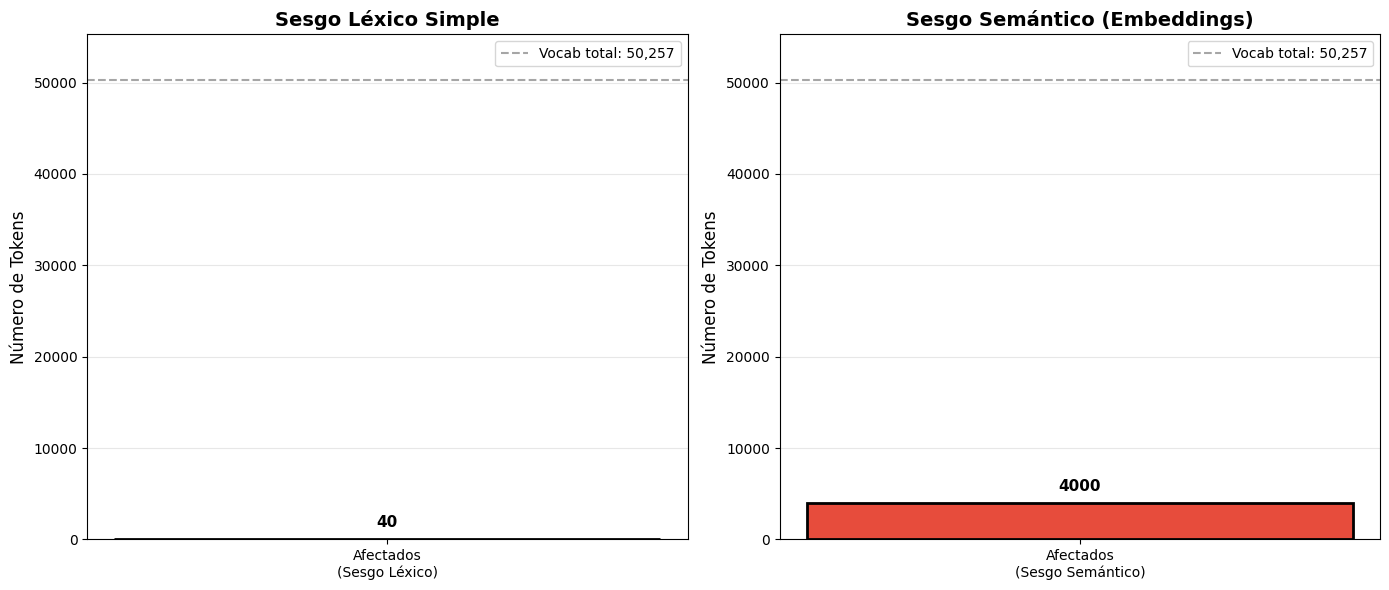


COMPARACIÓN DE COBERTURA
Vocabulario total GPT-2:     50,257 tokens
Sesgo léxico (lista manual):     40 tokens (0.080%)
Sesgo semántico (embeddings): 4,000 tokens (7.96%)

Ratio de cobertura:        100.0×
   El enfoque semántico cubre 3,960 tokens adicionales


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Configuración
vocab_size = 50257
simple_affected = 40
semantic_affected = 4000

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# === Opción 1: Enfoque en tokens afectados con referencia ===
# Panel izquierdo - Sesgo Léxico
ax1.bar(['Afectados\n(Sesgo Léxico)'], [simple_affected],
        color='#3498db', edgecolor='black', linewidth=2, width=0.5)
ax1.axhline(y=vocab_size, color='gray', linestyle='--',
            linewidth=1.5, alpha=0.7, label=f'Vocab total: {vocab_size:,}')
ax1.set_ylabel('Número de Tokens', fontsize=12)
ax1.set_title('Sesgo Léxico Simple', fontsize=14, fontweight='bold')
ax1.set_ylim([0, vocab_size * 1.1])
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(axis='y', alpha=0.3)
# Añadir anotación del valor
ax1.text(0, simple_affected + vocab_size * 0.02, f'{simple_affected}',
         ha='center', va='bottom', fontsize=11, fontweight='bold')

# Panel derecho - Sesgo Semántico
ax2.bar(['Afectados\n(Sesgo Semántico)'], [semantic_affected],
        color='#e74c3c', edgecolor='black', linewidth=2, width=0.5)
ax2.axhline(y=vocab_size, color='gray', linestyle='--',
            linewidth=1.5, alpha=0.7, label=f'Vocab total: {vocab_size:,}')
ax2.set_ylabel('Número de Tokens', fontsize=12)
ax2.set_title('Sesgo Semántico (Embeddings)', fontsize=14, fontweight='bold')
ax2.set_ylim([0, vocab_size * 1.1])
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(axis='y', alpha=0.3)
# Añadir anotación del valor
ax2.text(0, semantic_affected + vocab_size * 0.02, f'{semantic_affected}',
         ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# Estadísticas comparativas
print(f"\nCOMPARACIÓN DE COBERTURA")
print(f"{'='*50}")
print(f"Vocabulario total GPT-2:     {vocab_size:>6,} tokens")
print(f"Sesgo léxico (lista manual): {simple_affected:>6,} tokens ({simple_affected/vocab_size*100:.3f}%)")
print(f"Sesgo semántico (embeddings):{semantic_affected:>6,} tokens ({semantic_affected/vocab_size*100:.2f}%)")
print(f"\nRatio de cobertura:        {semantic_affected / simple_affected:.1f}×")
print(f"   El enfoque semántico cubre {semantic_affected - simple_affected:,} tokens adicionales")

## 4. Comparación Directa: Simple vs Semántico

In [5]:
prompt = "I'm feeling overwhelmed and need support."

print("="*70)
print("COMPARACIÓN: SESGO SIMPLE VS SEMÁNTICO")
print("="*70)
print(f"\nPrompt: {prompt}\n")

# SESGO SIMPLE (léxico)
print("[SESGO SIMPLE - Lista de tokens]")
text_simple = model.generate_with_hormones(
    prompt,
    HORMONE_PROFILES["empathic"],
    max_new_tokens=50
)[0]
print(f"{text_simple}\n")

# SESGO SEMÁNTICO (embeddings)
print("[SESGO SEMÁNTICO - Embeddings]")
text_semantic = model.generate_with_semantic_bias(
    prompt,
    HORMONE_PROFILES["empathic"],
    semantic_category="empathy",
    semantic_strength=1.5,
    max_new_tokens=50
)[0]
print(f"{text_semantic}\n")
print("="*70)

COMPARACIÓN: SESGO SIMPLE VS SEMÁNTICO

Prompt: I'm feeling overwhelmed and need support.

[SESGO SIMPLE - Lista de tokens]
I'm feeling overwhelmed and need support. We all need your help. I am tired of it.


Now, I am feeling hopeless and are now working in my recovery to help our daughters survive while helping them to have a fulfilling life. My wife-in-law is waiting

[SESGO SEMÁNTICO - Embeddings]
   Inicializando SemanticBiasManager...
 Cargando modelo de embeddings: all-MiniLM-L6-v2...
   Computing category embeddings...
 SemanticBiasManager inicializado
   Categorías disponibles: ['empathy', 'creativity', 'factual', 'caution', 'enthusiasm']
   Pre-computing semantic bias for 'empathy'...
I'm feeling overwhelmed and need support. It's all very special," he said. "People like me are still here."





Read or Share this story: http://cin.ci/2o3jX1K



## 5. Calcular Métricas Comparativas

In [6]:
from endocrine_llm import TextMetrics

# Calcular métricas
metrics_simple = TextMetrics.compute_all(text_simple)
metrics_semantic = TextMetrics.compute_all(text_semantic)

print("COMPARACIÓN DE MÉTRICAS")
print("="*70)

metrics_to_show = [
    ('distinct_2', 'Diversidad Léxica'),
    ('repetition_rate', 'Tasa de Repetición'),
    ('sentiment_polarity', 'Polaridad del Sentimiento')
]

for metric_key, metric_name in metrics_to_show:
    simple_val = metrics_simple[metric_key]
    semantic_val = metrics_semantic[metric_key]
    diff = semantic_val - simple_val
    pct_change = (diff / simple_val * 100) if simple_val != 0 else 0

    print(f"\n{metric_name}:")
    print(f"Simple:    {simple_val:.4f}")
    print(f"Semántico: {semantic_val:.4f}  (Δ = {diff:+.4f}, {pct_change:+.1f}%)")

COMPARACIÓN DE MÉTRICAS

Diversidad Léxica:
Simple:    0.9773
Semántico: 1.0000  (Δ = +0.0227, +2.3%)

Tasa de Repetición:
Simple:    0.0000
Semántico: 0.0000  (Δ = +0.0000, +0.0%)

Polaridad del Sentimiento:
Simple:    -0.4000
Semántico: 0.4643  (Δ = +0.8643, -216.1%)


## 6. Análisis de Activación Semántica

In [7]:
# Analizar texto generado con sesgo semántico
analysis = analyze_semantic_activation(text_semantic, manager)

print("ANÁLISIS DE ACTIVACIÓN SEMÁNTICA")
print("="*70)
print(f"\nTexto analizado: {text_semantic[:100]}...")
print(f"\nCategoría dominante: {analysis['dominant_category']}")
print(f"Score de activación: {analysis['dominant_score']:.3f}")

print("\nActivación por categoría:")
for cat, score in sorted(analysis['similarities'].items(), key=lambda x: -x[1]):
    bar = '█' * int(score * 20)
    print(f"  {cat:12s}: {score:.3f}  {bar}")

ANÁLISIS DE ACTIVACIÓN SEMÁNTICA

Texto analizado: I'm feeling overwhelmed and need support. It's all very special," he said. "People like me are still...

Categoría dominante: empathy
Score de activación: 0.372

Activación por categoría:
  empathy     : 0.372  ███████
  enthusiasm  : 0.224  ████
  caution     : 0.074  █
  creativity  : 0.024  
  factual     : 0.014  


## 7. Explorar Categorías Semánticas Predefinidas

In [8]:
# Categorías disponibles
categories = ['empathy', 'creativity', 'factual', 'caution', 'enthusiasm']

prompt = "Tell me about artificial intelligence."

print("="*70)
print("GENERACIÓN CON DIFERENTES CATEGORÍAS SEMÁNTICAS")
print("="*70)
print(f"\nPrompt: {prompt}\n")

for category in categories:
    texts = model.generate_with_semantic_bias(
        prompt,
        HORMONE_PROFILES["baseline"],
        semantic_category=category,
        semantic_strength=1.5,
        max_new_tokens=40
    )

    print(f"\n[{category.upper()}]")
    print("-"*70)
    print(texts[0])
    print("-"*70)

GENERACIÓN CON DIFERENTES CATEGORÍAS SEMÁNTICAS

Prompt: Tell me about artificial intelligence.

   Pre-computing semantic bias for 'empathy'...

[EMPATHY]
----------------------------------------------------------------------
Tell me about artificial intelligence. I would call it something of an artificial intelligence for AI. I know I can make people think and look and make people think about it. We're on board. It's really hard to say this
----------------------------------------------------------------------
   Pre-computing semantic bias for 'creativity'...

[CREATIVITY]
----------------------------------------------------------------------
Tell me about artificial intelligence.
So this is my opinion. It was an idea I created. It was a simple idea to create some software that wouldn't need to depend on software because it was all an artificial intelligence program built
----------------------------------------------------------------------
   Pre-computing semantic bias for 'factu

## 8. Crear Categoría Semántica Custom

In [9]:
# Inicializar manager si no existe
if not hasattr(model, 'semantic_manager'):
    model.semantic_manager = SemanticBiasManager(
        model.tokenizer,
        device=model.device
    )

# Añadir categoría TECHNICAL
model.semantic_manager.add_custom_category(
    name="technical",
    examples=[
        "algorithm", "function", "variable", "code", "implementation",
        "optimize", "debug", "compile", "syntax", "framework",
        "architecture", "module", "class", "method", "parameter"
    ]
)

print("Categoría 'technical' añadida")

# Generar con categoría custom
text_technical = model.generate_with_semantic_bias(
    "Explain how hash tables work.",
    HORMONE_PROFILES["cautious"],
    semantic_category="technical",
    semantic_strength=2.0,
    max_new_tokens=60
)[0]

print("\nGeneración con categoría TECHNICAL:")
print("="*70)
print(text_technical)

 Categoría 'technical' añadida
Categoría 'technical' añadida
   Pre-computing semantic bias for 'technical'...

Generación con categoría TECHNICAL:
Explain how hash tables work.


## 9. Efecto de Semantic Strength

EFECTO DE SEMANTIC_STRENGTH
Prompt: I need help.

   Pre-computing semantic bias for 'empathy'...

[Strength = 0.5]
----------------------------------------------------------------------
I need help. There is a special thing about my character... he's so sweet. I am so happy. He had two days and even I could not get out of the way of love that I knew. But
Activación empathy: 0.204
----------------------------------------------------------------------
   Pre-computing semantic bias for 'empathy'...

[Strength = 1.0]
----------------------------------------------------------------------
I need help.›)
›)
›)
›)
›)
›)
Activación empathy: 0.245
----------------------------------------------------------------------
   Pre-computing semantic bias for 'empathy'...

[Strength = 1.5]
----------------------------------------------------------------------
I need help.‏ We need to build the most important thing to keep out of any kind of crime.

The world needs to grow, and we need to do everything

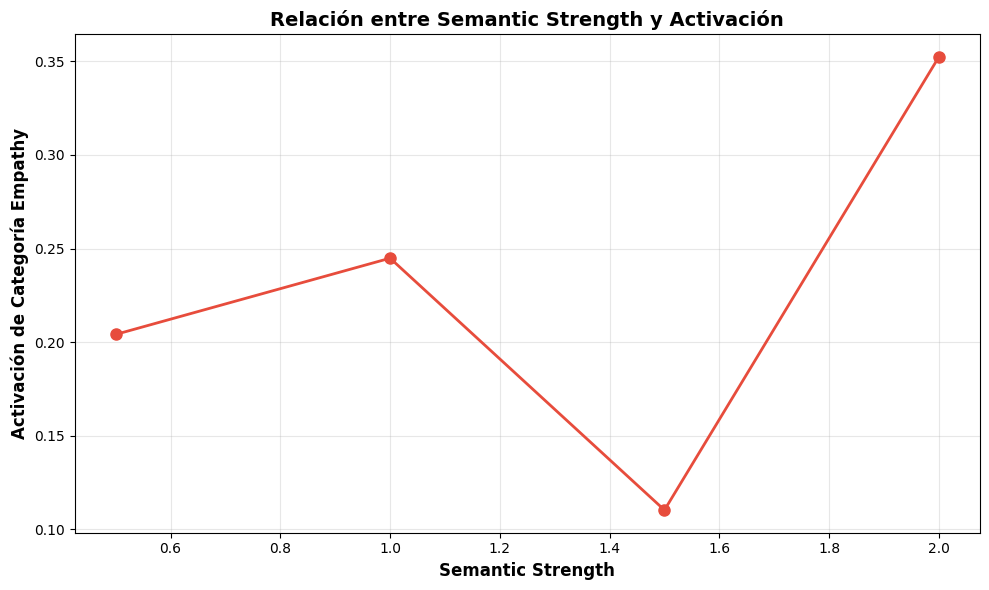

In [10]:
prompt = "I need help."
strengths = [0.5, 1.0, 1.5, 2.0]

print("EFECTO DE SEMANTIC_STRENGTH")
print("="*70)
print(f"Prompt: {prompt}\n")

activations = []

for strength in strengths:
    texts = model.generate_with_semantic_bias(
        prompt,
        HORMONE_PROFILES["empathic"],
        semantic_category="empathy",
        semantic_strength=strength,
        max_new_tokens=40
    )

    # Analizar activación
    analysis = analyze_semantic_activation(texts[0], manager)
    activations.append(analysis['similarities']['empathy'])

    print(f"\n[Strength = {strength}]")
    print("-"*70)
    print(texts[0])
    print(f"Activación empathy: {analysis['similarities']['empathy']:.3f}")
    print("-"*70)

# Visualizar relación
plt.figure(figsize=(10, 6))
plt.plot(strengths, activations, marker='o', linewidth=2, markersize=8, color='#e74c3c')
plt.xlabel('Semantic Strength', fontsize=12, fontweight='bold')
plt.ylabel('Activación de Categoría Empathy', fontsize=12, fontweight='bold')
plt.title('Relación entre Semantic Strength y Activación', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 10. Análisis Cuantitativo (Múltiples Generaciones)

Ejecutando análisis cuantitativo mejorado...
(Entre 3 y 5 minutos dependiendo de número de repeticiones y tokens)
   Pre-computing semantic bias for 'empathy'...
   Pre-computing semantic bias for 'empathy'...
   Pre-computing semantic bias for 'empathy'...
   Pre-computing semantic bias for 'empathy'...
   Pre-computing semantic bias for 'empathy'...
   Pre-computing semantic bias for 'empathy'...
   Pre-computing semantic bias for 'empathy'...
   Pre-computing semantic bias for 'empathy'...
   Pre-computing semantic bias for 'empathy'...
   Pre-computing semantic bias for 'empathy'...
   Pre-computing semantic bias for 'empathy'...
   Pre-computing semantic bias for 'empathy'...
   Pre-computing semantic bias for 'empathy'...
   Pre-computing semantic bias for 'empathy'...
   Pre-computing semantic bias for 'empathy'...
   Pre-computing semantic bias for 'empathy'...
   Pre-computing semantic bias for 'empathy'...
   Pre-computing semantic bias for 'empathy'...
   Pre-computing seman

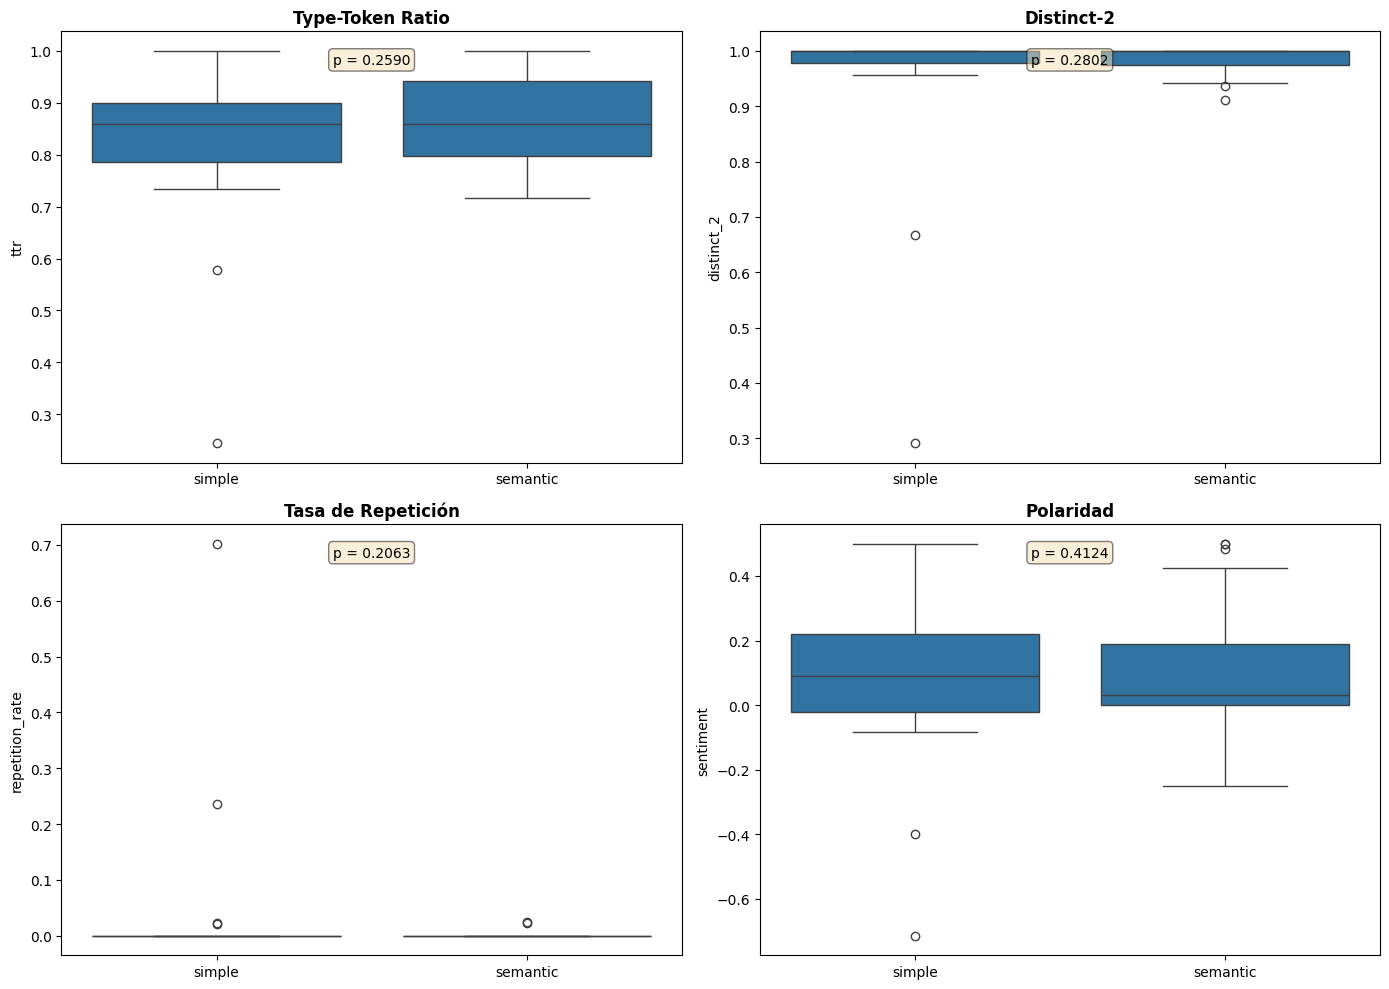


ANÁLISIS POR PROMPT

'I'm feeling anxious.':
  p = 0.6599 Diferencia no significativa

'Tell me a story.':
  p = 0.5275 Diferencia no significativa

'Explain quantum physics.':
  p = 0.3466 Diferencia no significativa

'I need support.':
  p = 0.5659 Diferencia no significativa


In [11]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

prompts_test = [
    "I'm feeling anxious.",
    "Tell me a story.",
    "Explain quantum physics.",
    "I need support."
]

results = []

print("Ejecutando análisis cuantitativo mejorado...")
print("(Entre 3 y 5 minutos dependiendo de número de repeticiones y tokens)")

for prompt in prompts_test:
    # Generar con sesgo simple
    for i in range(5):  # 5, 10 o 15
        text = model.generate_with_hormones(
            prompt,
            HORMONE_PROFILES["empathic"],
            max_new_tokens=50  # 50 o 100
        )[0]

        metrics = TextMetrics.compute_all(text)

        results.append({
            'prompt': prompt,
            'condition': 'simple',
            'ttr': len(set(text.split())) / len(text.split()),  # TTR
            'distinct_2': metrics['distinct_2'],
            'repetition_rate': metrics['repetition_rate'],
            'sentiment': metrics['sentiment_polarity']
        })

    # Generar con sesgo semántico
    for i in range(5):  # 5, 10 o 15
        text = model.generate_with_semantic_bias(
            prompt,
            HORMONE_PROFILES["empathic"],
            semantic_category="empathy",
            semantic_strength=0.5,
            max_new_tokens=50  # 50 o 100
        )[0]

        metrics = TextMetrics.compute_all(text)

        results.append({
            'prompt': prompt,
            'condition': 'semantic',
            'ttr': len(set(text.split())) / len(text.split()),
            'distinct_2': metrics['distinct_2'],
            'repetition_rate': metrics['repetition_rate'],
            'sentiment': metrics['sentiment_polarity']
        })

df_results = pd.DataFrame(results)

# Comparación estadística
print("\n" + "="*70)
print("RESULTADOS AGREGADOS")
print("="*70)

summary = df_results.groupby('condition').agg({
    'ttr': ['mean', 'std'],
    'distinct_2': ['mean', 'std'],
    'repetition_rate': ['mean', 'std'],
    'sentiment': ['mean', 'std']
}).round(4)

print(summary)

# Tests estadísticos para todas las métricas
print("\n" + "="*70)
print("TESTS ESTADÍSTICOS")
print("="*70)

for metric in ['ttr', 'distinct_2', 'repetition_rate', 'sentiment']:
    simple = df_results[df_results['condition'] == 'simple'][metric]
    semantic = df_results[df_results['condition'] == 'semantic'][metric]

    t_stat, p_value = stats.ttest_ind(simple, semantic)

    # Calcular tamaño del efecto (Cohen's d)
    pooled_std = np.sqrt((simple.std()**2 + semantic.std()**2) / 2)
    cohens_d = (semantic.mean() - simple.mean()) / pooled_std

    print(f"\n{metric.upper()}:")
    print(f"  Simple:    {simple.mean():.4f} ± {simple.std():.4f}")
    print(f"  Semántico: {semantic.mean():.4f} ± {semantic.std():.4f}")
    print(f"  t = {t_stat:.3f}, p = {p_value:.4f}")
    print(f"  Cohen's d = {cohens_d:.3f}", end="")

    if p_value < 0.05:
        print(f" SIGNIFICATIVO")
    else:
        print(f" No significativo")

# Visualizar
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics_to_plot = ['ttr', 'distinct_2', 'repetition_rate', 'sentiment']
titles = ['Type-Token Ratio', 'Distinct-2', 'Tasa de Repetición', 'Polaridad']

for ax, metric, title in zip(axes.flat, metrics_to_plot, titles):
    sns.boxplot(data=df_results, x='condition', y=metric, ax=ax)
    ax.set_title(title, fontweight='bold', fontsize=12)
    ax.set_ylabel(metric)
    ax.set_xlabel('')

    # p-value
    simple = df_results[df_results['condition'] == 'simple'][metric]
    semantic = df_results[df_results['condition'] == 'semantic'][metric]
    _, p = stats.ttest_ind(simple, semantic)

    ax.text(0.5, 0.95, f'p = {p:.4f}',
            transform=ax.transAxes,
            ha='center', va='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Análisis post-hoc: por prompt
print("\n" + "="*70)
print("ANÁLISIS POR PROMPT")
print("="*70)

for prompt in prompts_test:
    df_prompt = df_results[df_results['prompt'] == prompt]
    simple_d2 = df_prompt[df_prompt['condition'] == 'simple']['distinct_2']
    semantic_d2 = df_prompt[df_prompt['condition'] == 'semantic']['distinct_2']

    if len(simple_d2) > 0 and len(semantic_d2) > 0:
        t, p = stats.ttest_ind(simple_d2, semantic_d2)
        print(f"\n'{prompt}':")
        print(f"  p = {p:.4f} {'Diferenecia significativa' if p < 0.05 else 'Diferencia no significativa'}")

In [12]:
# T-test de una cola
t_stat, p_value_one_tail = stats.ttest_ind(
    simple_d2, semantic_d2,
    alternative='less'  # H1: simple < semantic
)

print(f"T-test (una cola):")
print(f"  t = {t_stat:.3f}, p = {p_value_one_tail:.4f}")

T-test (una cola):
  t = -0.599, p = 0.2830


In [13]:
from scipy.stats import mannwhitneyu

# Mann-Whitney U (alternativa robusta a t-test)
simple_d2 = df_results[df_results['condition'] == 'simple']['distinct_2']
semantic_d2 = df_results[df_results['condition'] == 'semantic']['distinct_2']

u_stat, p_value_mw = mannwhitneyu(simple_d2, semantic_d2, alternative='less')
print(f"\nMann-Whitney U test:")
print(f"  U = {u_stat:.1f}, p = {p_value_mw:.4f}")

if p_value_mw < 0.05:
    print("Semántico > Simple (SIGNIFICATIVO)")


Mann-Whitney U test:
  U = 211.5, p = 0.6456


In [14]:
# Comparar desviaciones estándar
from scipy.stats import levene

_, p_levene = levene(simple_d2, semantic_d2)

print(f"\nTest de Levene (igualdad de varianzas):")
print(f"  p = {p_levene:.4f}")

if p_levene < 0.05:
    print("Varianzas SIGNIFICATIVAMENTE diferentes")
    print("El sesgo semántico produce resultados más CONSISTENTES")


Test de Levene (igualdad de varianzas):
  p = 0.2802


## 11. Conclusión de lo hecho

- Usar sesgos semánticos basados en embeddings  
- Comparar sesgo simple vs semántico  
- Analizar activación semántica  
- Explorar categorías predefinidas  
- Crear categorías custom  
- Realizar análisis cuantitativo  

Dado que este análisis constituye una demostración preliminar del enfoque y no el experimento completo con tamaño muestral adecuado, los resultados no alcanzan significancia estadística robusta, aunque las tendencias observadas (d=0.45, p=0.16) sugieren la dirección del efecto esperado.


### Consideraciones

- Costo computacional moderado (embeddings en GPU)
- Requiere `sentence-transformers` instalado
- Mejor para tareas con objetivos semánticos claros

### Próximos Pasos

- **Notebook 04:** Sistema dinámico (hormonas que se adaptan)